In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output

Download the caltech_birds2011 dataset

In [2]:
dataset, info = tfds.load('caltech_birds2011:0.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2011/0.1.1.incompleteQYY8IF/caltech_birds2011-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2011/0.1.1.incompleteQYY8IF/caltech_birds2011-test.tfrecord


Dataset caltech_birds2011 downloaded and prepared to /root/tensorflow_datasets/caltech_birds2011/0.1.1. Subsequent calls will reuse this data.


Change input_image type to float32 and normalize it to [0,1]

Normalize input_mask to [0,1]

In [20]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask /= 255.0
  return input_image, input_mask

Resize datapoint['image'] to (128,128)

Resize datapoint['segmentation_mask'] to (128,128)

Flip images from left to right

In [21]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [22]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [23]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [24]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [26]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i>0:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray')
    else:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

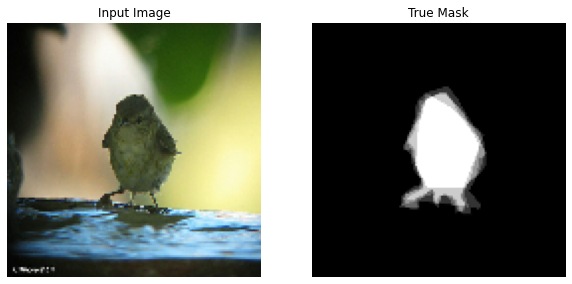

In [27]:
for image, mask in train.take(6):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# U-net architecture

Encoder | Bottleneck | Decoder
--- | --- | ---
CL(32,4,2) | CR(256,4,2) | TBDR(256,4,2)
CBL(64,4,2) |  | TBDR(128,4,2)
CBL(128,4,2) |  | TBR(64,4,2)
CBL(256,4,2) |  | TBR(32,4,2)
| | TS(1,4,2)

 Acronyms: C=convolution, B=batch normalization, L= leaky relu(alpha=0.2), D=dropout, R=relu,
T=transpose convolution, S=sigmoid. 

The numbers in parentheses indicate the number of ﬁlters, ﬁlter size, and stride of the convolution
ﬁlters, respectively.

Initialize weights with mean=0 and Standard deviation=0.02

In [39]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = tf.random_normal_initializer(0., 0.02)
	# add convolution layer
	x = tf.keras.layers.Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		x = tf.keras.layers.BatchNormalization()(x)
	# leaky relu activation
	x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
	return x

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = tf.random_normal_initializer(0., 0.02)
	# add transpose convolution layer
	x = tf.keras.layers.Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	x = tf.keras.layers.BatchNormalization()(x)
	# conditionally add dropout
	if dropout:
		x = tf.keras.layers.Dropout(0.5)(x)
	# merge with skip connection
	x = tf.keras.layers.Concatenate()([x, skip_in])
	# relu activation
	x = tf.keras.layers.Activation('relu')(x)
	return x

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 64, 64, 32)   1568        input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_16 (LeakyReLU)      (None, 64, 64, 32)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 64)   32832       leaky_re_lu_16[0][0]             
____________________________________________________________________________________________

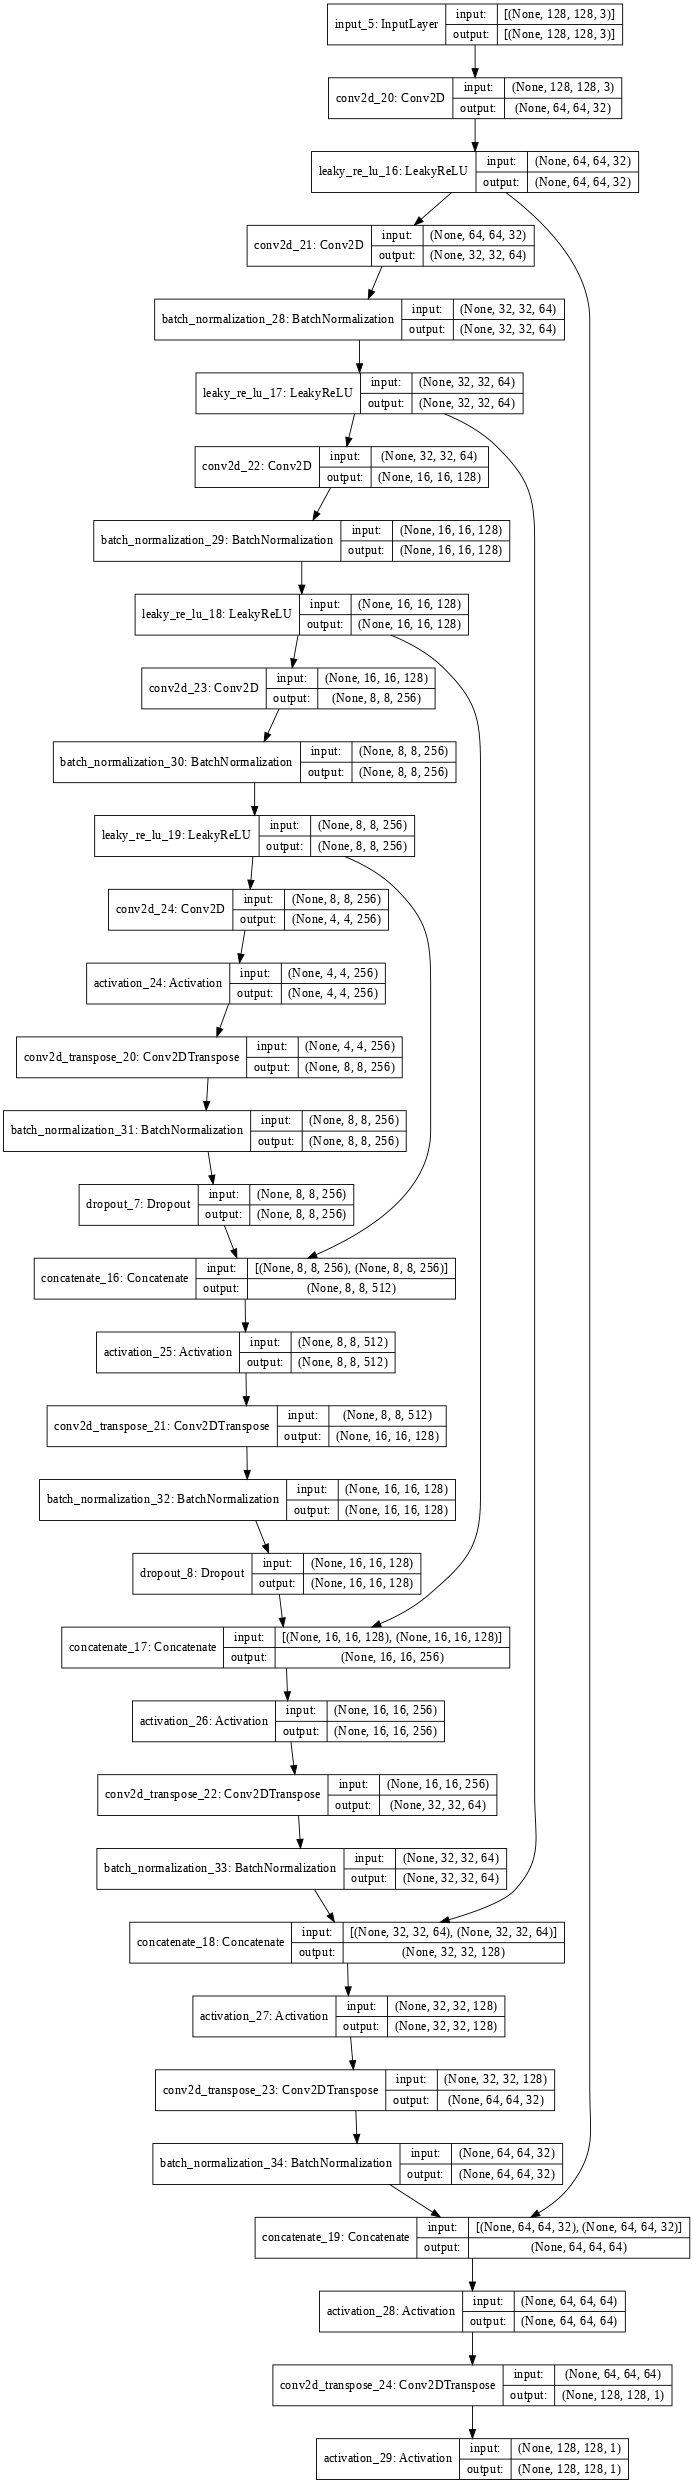

In [40]:
# define the Unet model
def Unet():
	# weight initialization
	init = tf.random_normal_initializer(0., 0.02)
	# image input
	in_image = tf.keras.layers.Input(shape=[128,128,3])
	# encoder model
	e1 = define_encoder_block(in_image, 32, batchnorm=False)
	e2 = define_encoder_block(e1, 64)
	e3 = define_encoder_block(e2, 128)
	e4 = define_encoder_block(e3, 256)

	# bottleneck, conv and relu activation
	b = tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e4)
	b = tf.keras.layers.Activation('relu')(b)
  
	# decoder model
	d1 = decoder_block(b, e4, 256)
	d2 = decoder_block(d1, e3, 128)
	d3 = decoder_block(d2, e2, 64, dropout=False)
	d4 = decoder_block(d3, e1, 32, dropout=False)
	# Conv2D Transpose
	g = tf.keras.layers.Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d4)
  # Sigmoid activation
	out_image = tf.keras.layers.Activation('sigmoid')(g)
	# define model
	model = tf.keras.Model(in_image, out_image)
	return model

Unet = Unet()
Unet.summary()
tf.keras.utils.plot_model(Unet, show_shapes=True, dpi=64)

# Compile the model
Use Adam optimizer with learning rate 0.001 and BinaryCrossentropy with from_logits=True

Set accuracy for metrics

In [37]:
Unet.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Fit the model

In [31]:
EPOCHS = 20
VAL_SUBSPLITS = 5 
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
#Complete with train_data, epochs, steps_per_epoch, validation_steps, validation_data
model_history = Unet.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=test_dataset)

Epoch 1/20
93/93 [==============================] - 21s 193ms/step - loss: 0.4032 - accuracy: 0.8027 - val_loss: 0.2400 - val_accuracy: 0.8671
Epoch 2/20
93/93 [==============================] - 9s 100ms/step - loss: 0.2054 - accuracy: 0.8777 - val_loss: 0.2102 - val_accuracy: 0.8787
Epoch 3/20
93/93 [==============================] - 9s 101ms/step - loss: 0.1791 - accuracy: 0.8880 - val_loss: 0.2390 - val_accuracy: 0.8711
Epoch 4/20
93/93 [==============================] - 9s 101ms/step - loss: 0.1615 - accuracy: 0.8958 - val_loss: 0.2096 - val_accuracy: 0.8848
Epoch 5/20
93/93 [==============================] - 9s 101ms/step - loss: 0.1454 - accuracy: 0.9026 - val_loss: 0.1695 - val_accuracy: 0.8957
Epoch 6/20
93/93 [==============================] - 9s 99ms/step - loss: 0.1298 - accuracy: 0.9089 - val_loss: 0.1763 - val_accuracy: 0.8942
Epoch 7/20
93/93 [==============================] - 9s 99ms/step - loss: 0.1153 - accuracy: 0.9147 - val_loss: 0.1697 - val_accuracy: 0.8998
Epoch 8

Draw loss and validation loss history

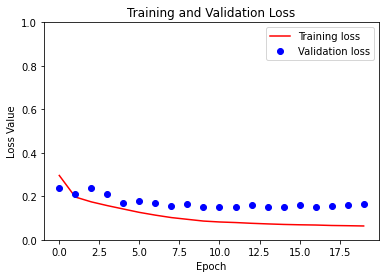

In [32]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Predict
Draw predict images

In [33]:
def show_predictions(dataset, num=10):
  for image, mask in dataset.take(num):
      #Prediction
      pred_mask = Unet.predict(image)
      display([image[0], mask[0], pred_mask[0]])

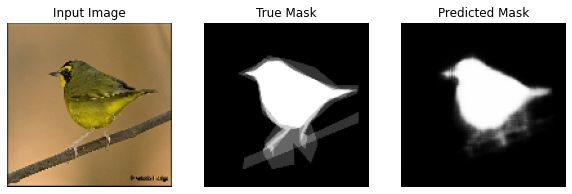

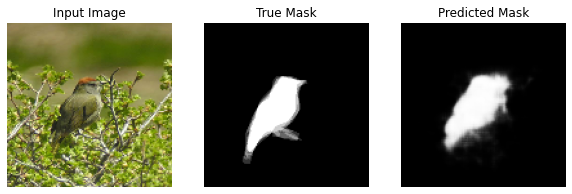

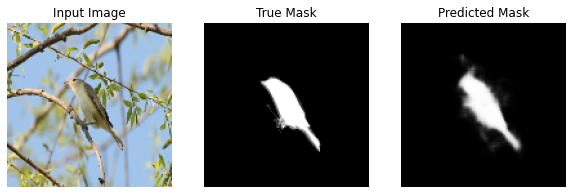

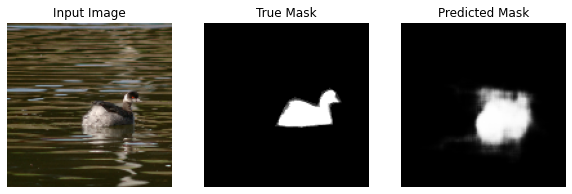

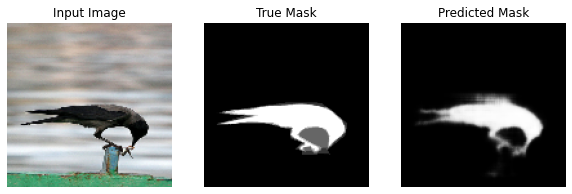

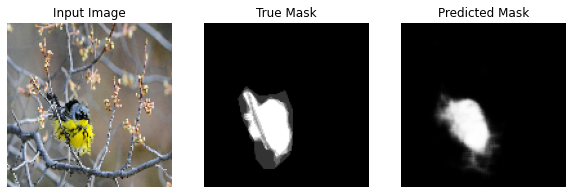

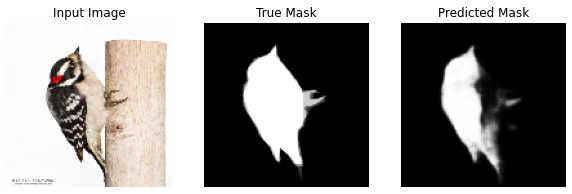

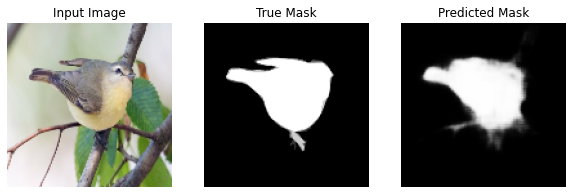

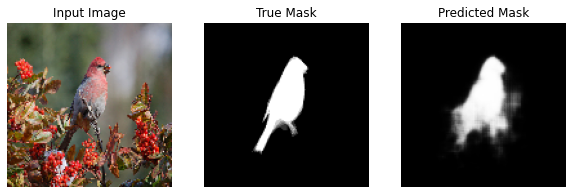

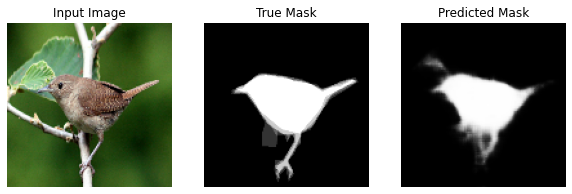

In [34]:
show_predictions(test_dataset)